In [ ]:
%cd ..

import torch
import pennylane as qml
from pennylane import numpy as np

from src.nn.encodings.pennylane_templates import angle_embedding, amplitude_embedding, QAOA_embedding
from src.nn.encodings.IQP_embedding import custom_iqp_embedding
from src.nn.encodings.NQE_embedding import NQE_embedding
from src.nn.encodings.ring_embedding import ring_embedding
from src.nn.encodings.waterfall_embedding import waterfall_embedding

from src.nn.ansatz.no_entanglement_circuit import no_entanglement_random_circuit
from src.nn.ansatz.full_entanglement_circuit import full_entanglement_circuit
from src.nn.ansatz.NQ_circuit import NQ_circuit
from src.nn.ansatz.ring_circuit import ring_circuit

from src.nn.measurements.default import default_measurement

from src.utils.dataset import load_dataset
from src.nn.models.hybrid.HQNN_quanv import FlexHybridCNN
from src.utils.training import Trainer


import logging
logging.getLogger("pennylane").setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='IPython')

In [2]:
limit = 100
dataset_ = "EuroSAT"
image_size = 32
test_size = 0.2
output = 'np' # 'np' or 'dl'
    
if dataset_ == "EuroSAT":
    allowed_classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
elif dataset_ == "DeepSat4":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Other']
elif dataset_ == "DeepSat6":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Roads', 'Buildings' , 'WaterBodies']
    
config = {
    #'allowed_classes': ['Forest', 'Highway', 'Pasture', 'SeaLake']
    #'allowed_classes': ['AnnualCrop', 'Forest', 'Highway', 'Pasture', 'River', 'SeaLake']
}

allowed_classes = config.get('allowed_classes', allowed_classes)
train_loader, val_loader = load_dataset(dataset_, output, limit, allowed_classes, image_size, test_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")
torch.backends.cudnn.benchmark = True



Class distribution in train set:
Class 0: 80
Class 1: 80
Class 2: 80
Class 3: 80
Class 4: 80
Class 5: 80
Class 6: 80
Class 7: 80
Class 8: 80
Class 9: 80

Class distribution in validation set:
Class 0: 20
Class 1: 20
Class 2: 20
Class 3: 20
Class 4: 20
Class 5: 20
Class 6: 20
Class 7: 20
Class 8: 20
Class 9: 20


## Choose params - FlexHybridCNN

In [3]:
qkernel_shape = 2

# ENCODINGS

amplitude_encoding_params = {
    "func":  amplitude_embedding,
    "func_params": {
        "normalize" : True,
        "pad_with": 0.0,
    }
}

angle_encoding_params = {
    "func": angle_embedding,
    "func_params": {
        "rotation" : "X"
    }
}

iqp_encoding_params = {
    "func": custom_iqp_embedding,
    "func_params": {
        "n_repeats": 2,
        "pattern": None
    }
}

nqe_encoding_params = {
    "func": NQE_embedding,
    "func_params": {
        "n_repeats": 1
    }
}

qaoa_encoding_params = {
    "func": QAOA_embedding,
    "func_params": {
        "weights": None,
        "local_field": 'Y',
        "n_layers": 1
    }
}

ring_encoding_params = {
    "func": ring_embedding,
    "func_params": {
        "n_repeats": 1
    }
}

waterfall_encoding_params = {
    "func": waterfall_embedding,
    "func_params": {
        "weights": None,
    }
}

# Circuits

no_entanglement_circuit_params = {
    "func": no_entanglement_random_circuit,
    "func_params": {
        "weights": torch.rand(qkernel_shape**2, device = device) % np.pi,
    }
}

num_layers = 2
entanglement_circuit_params = {
    "func": full_entanglement_circuit,
    "func_params": {
        "num_layers": num_layers,
        "weights": torch.randn(num_layers, qkernel_shape**2, 3, device=device) % np.pi,
    }
}

nq_circuit_params = {
    "func": NQ_circuit,
    "func_params": {
        "weights": torch.randn(3*(qkernel_shape**2),  2, device=device) % np.pi,
    }
}

ring_circuit_params = {
    "func": ring_circuit,
    "func_params": {
        "weights": torch.randn(3*(qkernel_shape**2),  2, device=device),
    }
}

# Measurement

measurement_params = {
    "func": default_measurement,
    "func_params": {
        "observable": qml.PauliZ,
    }
}


In [4]:
embedding = waterfall_encoding_params
circuit = no_entanglement_circuit_params
measurement = measurement_params

use_quantum, log_mlflow, plot = True, True, True

learning_rate  = 0.01
epochs = 10
n_classes = len(allowed_classes)

early_stopping, patience = True, 3
use_schedulefree = True

if use_quantum:
        emb = embedding["func"]
        circ = circuit["func"]
        name_run =f"FlexHybridCNN {emb.__name__} {circ.__name__} limit = {limit}"
else:
        name_run = f"FlexHybridCNN classic limit = {limit}"

name_prueba = dataset_ + " " + str(image_size) + "x" + str(image_size)

print("Testing with the", dataset_, "dataset")

Testing with the EuroSAT dataset


# FlexHybridCNN - 32x32x3

In [5]:
model_flexhybrid = FlexHybridCNN(embedding_params = embedding,
                                    variational_params= circuit,
                                    measurement_params= measurement,
                                    n_classes = n_classes,
                                    use_quantum = use_quantum,
                                    qkernel_shape = qkernel_shape,
                                    epochs = epochs,
                                    dataset = dataset_,
                                    image_size = image_size,
                                )

trainer = Trainer(model = model_flexhybrid,
                  train_loader = train_loader,
                  val_loader = val_loader,
                  epochs = epochs,
                  early_stopping = early_stopping,
                  patience = patience,
                  log = log_mlflow,
                  mlflow_project = name_prueba,
                  mlflow_run_name = name_run,
                  use_quantum = use_quantum,
                  plot = plot,
                  allowed_classes = allowed_classes,
                  lr = learning_rate,
                  use_schedulefree = use_schedulefree
                 )

Epoch [1/10]: Train Loss = 2.1004, Train Acc = 19.25%, Val Loss = 1.9428, Val Acc = 27.00%
Epoch [2/10]: Train Loss = 1.7645, Train Acc = 37.25%, Val Loss = 1.7092, Val Acc = 42.00%
Epoch [3/10]: Train Loss = 1.5241, Train Acc = 48.75%, Val Loss = 1.5498, Val Acc = 46.50%
Epoch [4/10]: Train Loss = 1.3628, Train Acc = 54.75%, Val Loss = 1.4556, Val Acc = 51.00%
Epoch [5/10]: Train Loss = 1.2054, Train Acc = 59.75%, Val Loss = 1.4018, Val Acc = 54.50%
Epoch [6/10]: Train Loss = 1.0957, Train Acc = 63.38%, Val Loss = 1.3747, Val Acc = 56.50%
Epoch [7/10]: Train Loss = 0.9759, Train Acc = 67.88%, Val Loss = 1.3566, Val Acc = 57.00%
Epoch [8/10]: Train Loss = 0.8925, Train Acc = 69.75%, Val Loss = 1.3459, Val Acc = 58.00%
Epoch [9/10]: Train Loss = 0.7949, Train Acc = 75.62%, Val Loss = 1.3453, Val Acc = 59.50%
Epoch [10/10]: Train Loss = 0.7280, Train Acc = 76.38%, Val Loss = 1.3498, Val Acc = 60.00%


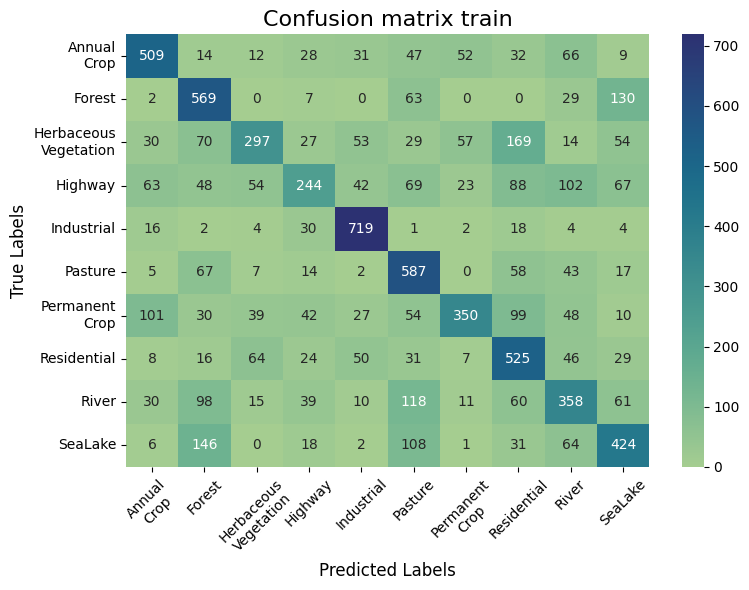

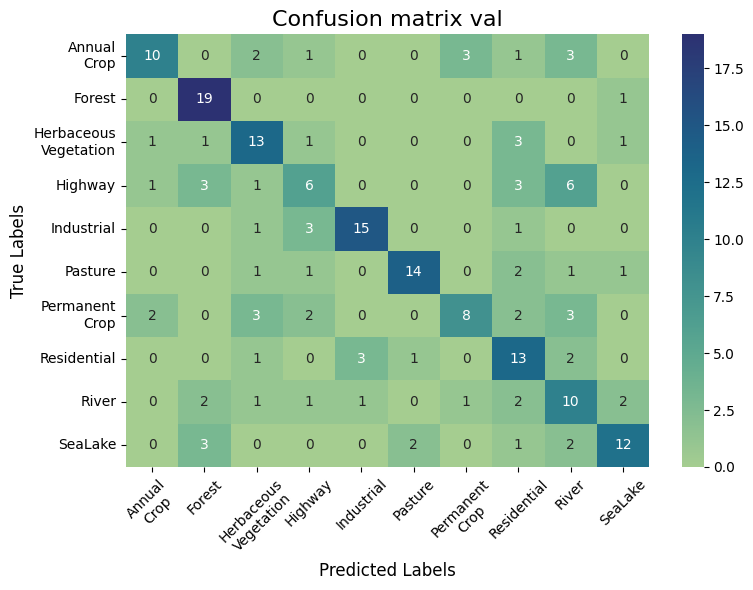

In [6]:
trainer.fit()

In [7]:
embedding = nqe_encoding_params
circuit = ring_circuit_params
measurement = measurement_params

if use_quantum:
        emb = embedding["func"]
        circ = circuit["func"]
        name_run =f"FlexHybridCNN {emb.__name__} {circ.__name__} limit = {limit}"
else:
        name_run = f"FlexHybridCNN classic limit = {limit}"


print("Testing with the", dataset_, "dataset")

Testing with the EuroSAT dataset


In [8]:
model_flexhybrid = FlexHybridCNN(embedding_params = embedding,
                                    variational_params= circuit,
                                    measurement_params= measurement,
                                    n_classes = n_classes,
                                    use_quantum = use_quantum,
                                    qkernel_shape = qkernel_shape,
                                    epochs = epochs,
                                    dataset = dataset_,
                                    image_size = image_size,
                                )

trainer = Trainer(model = model_flexhybrid,
                  train_loader = train_loader,
                  val_loader = val_loader,
                  epochs = epochs,
                  early_stopping = early_stopping,
                  patience = patience,
                  log = log_mlflow,
                  mlflow_project = name_prueba,
                  mlflow_run_name = name_run,
                  use_quantum = use_quantum,
                  plot = plot,
                  allowed_classes = allowed_classes,
                  lr = learning_rate,
                  use_schedulefree = use_schedulefree
                 )

Epoch [1/10]: Train Loss = 2.1774, Train Acc = 19.62%, Val Loss = 2.1007, Val Acc = 20.00%
Epoch [2/10]: Train Loss = 1.8661, Train Acc = 38.25%, Val Loss = 2.0016, Val Acc = 22.50%
Epoch [3/10]: Train Loss = 1.5370, Train Acc = 56.88%, Val Loss = 1.9579, Val Acc = 30.50%
Epoch [4/10]: Train Loss = 1.1625, Train Acc = 71.38%, Val Loss = 1.9688, Val Acc = 30.00%
Epoch [5/10]: Train Loss = 0.8367, Train Acc = 80.75%, Val Loss = 2.0301, Val Acc = 30.50%
Early stopping at epoch 6


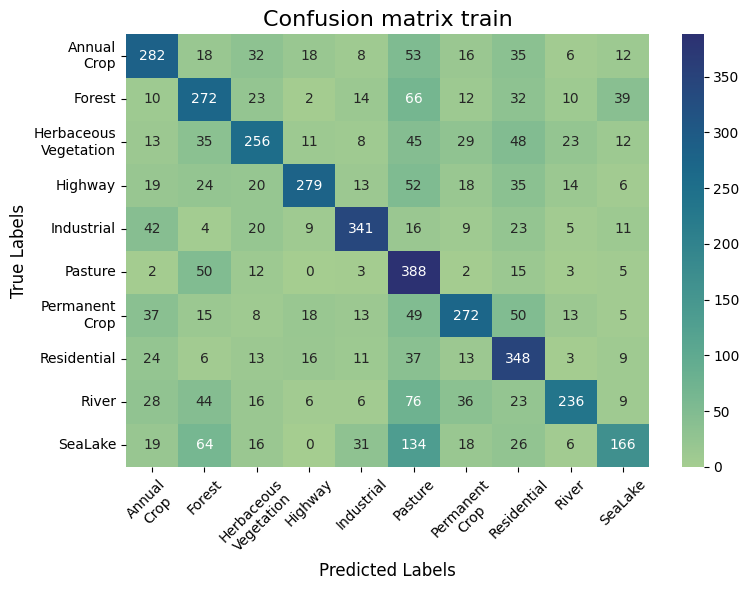

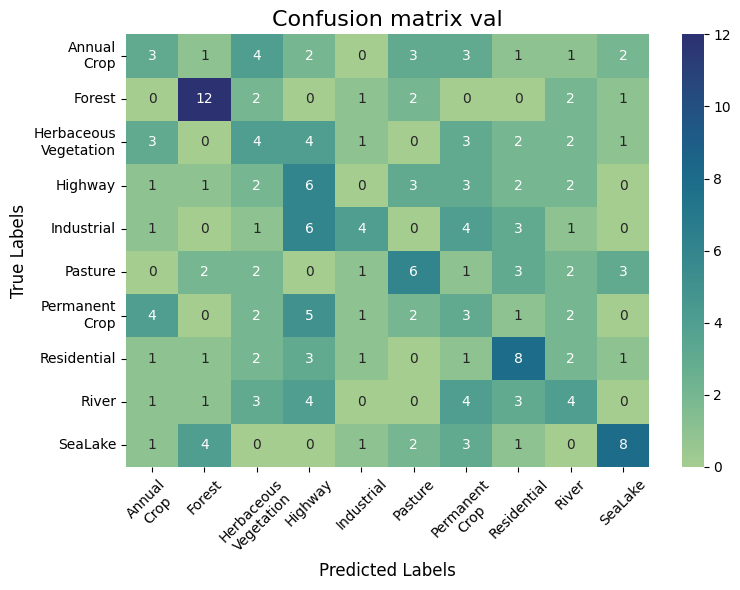

In [9]:
trainer.fit()

# FlexHybridCNN - 16x16x3

In [10]:
limit = 100
dataset_ = "EuroSAT"
image_size = 16
test_size = 0.2
output = 'np' # 'np' or 'dl'
    
if dataset_ == "EuroSAT":
    allowed_classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
elif dataset_ == "DeepSat4":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Other']
elif dataset_ == "DeepSat6":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Roads', 'Buildings' , 'WaterBodies']
    
config = {
    #'allowed_classes': ['Forest', 'Highway', 'Pasture', 'SeaLake']
    #'allowed_classes': ['AnnualCrop', 'Forest', 'Highway', 'Pasture', 'River', 'SeaLake']
}

allowed_classes = config.get('allowed_classes', allowed_classes)
train_loader, val_loader = load_dataset(dataset_, output, limit, allowed_classes, image_size, test_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")
torch.backends.cudnn.benchmark = True


Class distribution in train set:
Class 0: 80
Class 1: 80
Class 2: 80
Class 3: 80
Class 4: 80
Class 5: 80
Class 6: 80
Class 7: 80
Class 8: 80
Class 9: 80

Class distribution in validation set:
Class 0: 20
Class 1: 20
Class 2: 20
Class 3: 20
Class 4: 20
Class 5: 20
Class 6: 20
Class 7: 20
Class 8: 20
Class 9: 20


In [11]:
embedding = waterfall_encoding_params
circuit = no_entanglement_circuit_params
measurement = measurement_params

if use_quantum:
        emb = embedding["func"]
        circ = circuit["func"]
        name_run =f"FlexHybridCNN {emb.__name__} {circ.__name__} limit = {limit}"
else:
        name_run = f"FlexHybridCNN classic limit = {limit}"

name_prueba = dataset_ + " " + str(image_size) + "x" + str(image_size)

print("Testing with the", dataset_, "dataset")

Testing with the EuroSAT dataset


In [12]:
model_flexhybrid = FlexHybridCNN(embedding_params = embedding,
                                    variational_params= circuit,
                                    measurement_params= measurement,
                                    n_classes = n_classes,
                                    use_quantum = use_quantum,
                                    qkernel_shape = qkernel_shape,
                                    epochs = epochs,
                                    dataset = dataset_,
                                    image_size = image_size,
                                )

trainer = Trainer(model = model_flexhybrid,
                  train_loader = train_loader,
                  val_loader = val_loader,
                  epochs = epochs,
                  early_stopping = early_stopping,
                  patience = patience,
                  log = log_mlflow,
                  mlflow_project = name_prueba,
                  mlflow_run_name = name_run,
                  use_quantum = use_quantum,
                  plot = plot,
                  allowed_classes = allowed_classes,
                  lr = learning_rate,
                  use_schedulefree = use_schedulefree
                 )

2025/02/24 13:31:53 INFO mlflow.tracking.fluent: Experiment with name 'EuroSAT 16x16' does not exist. Creating a new experiment.


Epoch [1/10]: Train Loss = 2.0790, Train Acc = 21.75%, Val Loss = 1.9728, Val Acc = 26.00%
Epoch [2/10]: Train Loss = 1.7611, Train Acc = 38.62%, Val Loss = 1.7148, Val Acc = 39.00%
Epoch [3/10]: Train Loss = 1.5140, Train Acc = 49.75%, Val Loss = 1.5648, Val Acc = 46.00%
Epoch [4/10]: Train Loss = 1.3512, Train Acc = 55.88%, Val Loss = 1.5252, Val Acc = 49.00%
Epoch [5/10]: Train Loss = 1.2181, Train Acc = 59.88%, Val Loss = 1.4636, Val Acc = 54.50%
Epoch [6/10]: Train Loss = 1.1091, Train Acc = 64.62%, Val Loss = 1.4479, Val Acc = 55.00%
Epoch [7/10]: Train Loss = 1.0246, Train Acc = 67.00%, Val Loss = 1.4557, Val Acc = 55.50%
Epoch [8/10]: Train Loss = 0.9330, Train Acc = 70.75%, Val Loss = 1.4591, Val Acc = 56.00%
Early stopping at epoch 9


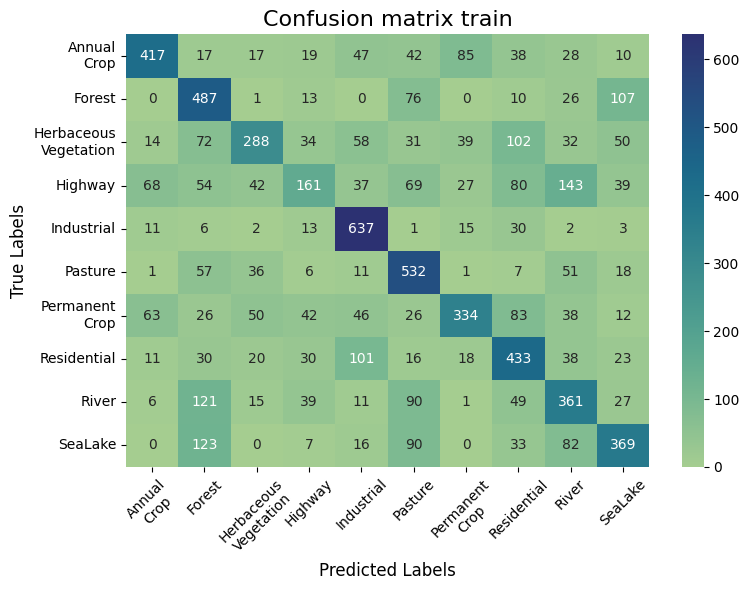

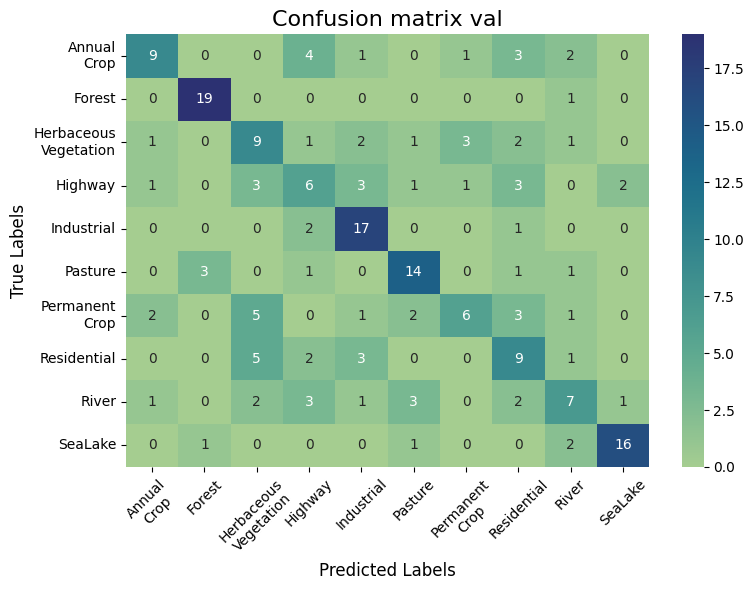

In [13]:
trainer.fit()

In [14]:
embedding = angle_encoding_params
circuit = nq_circuit_params
measurement = measurement_params

if use_quantum:
        emb = embedding["func"]
        circ = circuit["func"]
        name_run =f"FlexHybridCNN {emb.__name__} {circ.__name__} limit = {limit}"
else:
        name_run = f"FlexHybridCNN classic limit = {limit}"

print("Testing with the", dataset_, "dataset")

Testing with the EuroSAT dataset


In [15]:
model_flexhybrid = FlexHybridCNN(embedding_params = embedding,
                                    variational_params= circuit,
                                    measurement_params= measurement,
                                    n_classes = n_classes,
                                    use_quantum = use_quantum,
                                    qkernel_shape = qkernel_shape,
                                    epochs = epochs,
                                    dataset = dataset_,
                                    image_size = image_size,
                                )

trainer = Trainer(model = model_flexhybrid,
                  train_loader = train_loader,
                  val_loader = val_loader,
                  epochs = epochs,
                  early_stopping = early_stopping,
                  patience = patience,
                  log = log_mlflow,
                  mlflow_project = name_prueba,
                  mlflow_run_name = name_run,
                  use_quantum = use_quantum,
                  plot = plot,
                  allowed_classes = allowed_classes,
                  lr = learning_rate,
                  use_schedulefree = use_schedulefree
                 )

Epoch [1/10]: Train Loss = 2.0408, Train Acc = 24.00%, Val Loss = 1.8247, Val Acc = 31.50%
Epoch [2/10]: Train Loss = 1.7237, Train Acc = 34.12%, Val Loss = 1.6598, Val Acc = 39.00%
Epoch [3/10]: Train Loss = 1.5510, Train Acc = 43.12%, Val Loss = 1.5504, Val Acc = 43.50%
Epoch [4/10]: Train Loss = 1.4299, Train Acc = 47.00%, Val Loss = 1.4755, Val Acc = 48.00%
Epoch [5/10]: Train Loss = 1.3136, Train Acc = 53.50%, Val Loss = 1.4146, Val Acc = 51.50%
Epoch [6/10]: Train Loss = 1.2504, Train Acc = 57.50%, Val Loss = 1.3626, Val Acc = 52.50%
Epoch [7/10]: Train Loss = 1.1651, Train Acc = 60.50%, Val Loss = 1.3289, Val Acc = 53.00%
Epoch [8/10]: Train Loss = 1.1533, Train Acc = 60.62%, Val Loss = 1.3035, Val Acc = 54.00%
Epoch [9/10]: Train Loss = 1.0832, Train Acc = 63.12%, Val Loss = 1.2877, Val Acc = 54.50%
Epoch [10/10]: Train Loss = 1.0213, Train Acc = 66.50%, Val Loss = 1.2730, Val Acc = 55.00%


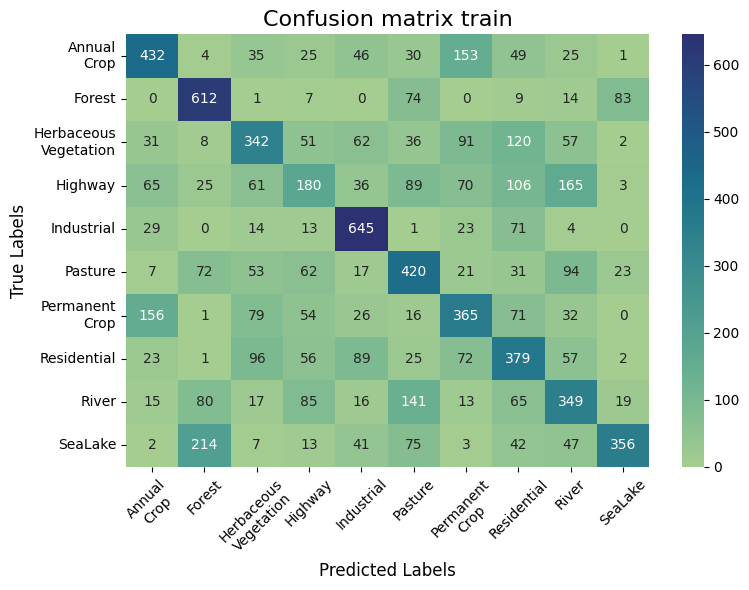

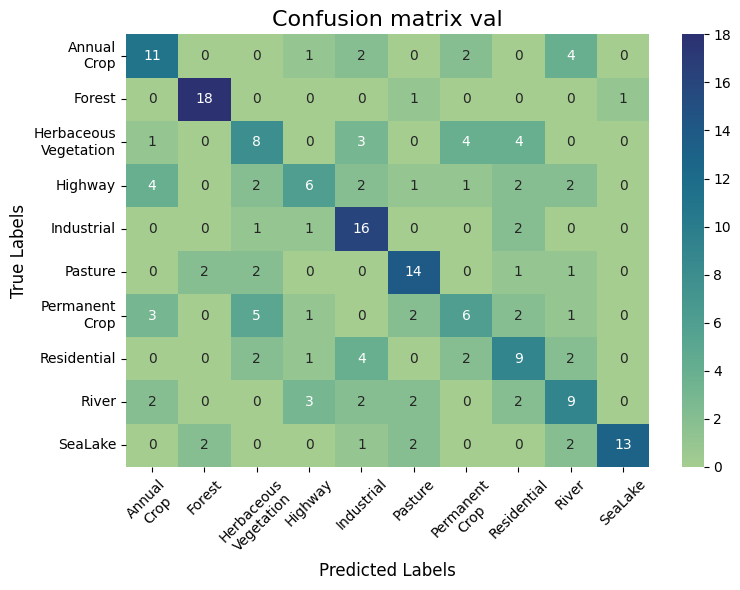

In [16]:
trainer.fit()